Funcion objetivo:

Maximizar z = 70x1 + 91x2 + 50x2 + 61x4 + 21x5

Minimizar z = 170x1 + 310x2 + 60x3 + 101x4 + 11x5

sujeto a:

      x1 ≤ 15
      x2 ≤ 10
      x3 ≤ 25
      x4 ≤ 4
      x5 ≤ 30
      
      170x1 + 310x2 ≤ 3800
      60x3 + 101x4 ≤ 2800
      101x4 + 11x5 ≤ 3500

In [243]:
import random
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

Nodo y Arco Consistencia


In [244]:
# Nodo Consistencia
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [245]:
# Restricciones
constraints = {

    ('x1', 'x2'): lambda x1, x2:  170*x1 <= 3800-310*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-310*x2 >= 170*x1,

    ('x3', 'x4'): lambda x3, x4:  60*x3 <= 2800-101*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-101*x4 >= 60*x3,

    ('x3', 'x5'): lambda x3, x5:  60*x3 <= 3500-11*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-11*x5 >= 60*x3,

}

In [246]:
# Implementación de AC3
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors


In [247]:
# Arcos de las restricciones del problema
arcs = [
    ('x1','x2'), ('x2','x1'),
    ('x3','x4'), ('x4','x3'),
    ('x3', 'x5'), ('x5','x3')
]

ac3(arcs)

print("x1: " + str(domains['x1']))
print("x2: " + str(domains['x2']))
print("x3: " + str(domains['x3']))
print("x4: " + str(domains['x4']))
print("x5: " + str(domains['x5']))

x1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
x2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
x4: [0, 1, 2, 3, 4]
x5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [248]:
class Problema:
  def __init__(self):
    self.epsilon = 5000
    self.dimensiones = 5
    self.limites = {
      'x1': (0, 15),
      'x2': (0, 10),
      'x3': (0, 25),
      'x4': (0, 4),
      'x5': (0, 30)
    }

    self.costos = {
      'x1': 170,
      'x2': 310,
      'x3': 60,
      'x4': 101,
      'x5': 11
    }

    self.presMaxTv = 3800
    self.presMaxDyR = 2800
    self.presMaxDyR = 3500

  def check(self, x):
    # Chequeo de restricciones de presupuesto
    costo_tv = self.costos['x1'] * x[0] + self.costos['x2'] * x[1]
    costo_print = self.costos['x3'] * x[2] + self.costos['x4'] * x[3]
    costo_combined = self.costos['x3'] * x[2] + self.costos['x5'] * x[4]
        
    if costo_tv > self.presMaxTv:
      return False
    if costo_print > self.presMaxDyR:
      return False
    if costo_combined > self.presMaxDyR:
      return False

    # Chequeo de límites de cantidad de anuncios
    for i, (c_min, c_max) in enumerate(self.limites.values()):
      if not (c_min <= x[i] <= c_max):
        return False

    # Chequeo de epsilon-constraint
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    if totalCosto > self.epsilon:
      return False

    return True
  
  def checkCostos(self, x):
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    return totalCosto
  
  def checkQuality(self, x):
     totalQuality = 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
     return totalQuality

  def eval(self, x):

    # Se evalua el fitness utilizando la nueva funcion
    #return self.scalarazing(x)

    # Se evalua el fitness
    return 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
  

  def sigmoide(self, x, alpha, x0):
    return 1/(1+np.exp(-alpha*(x-x0)))
  
  def find_y_interval(self, y, intervals):
    interval_width = 1 / intervals
    for i in range(intervals):
        if i * interval_width <= y < (i + 1) * interval_width:
            return i
    return intervals - 1 if y == 1 else None
  
  def master_sigmoide(self, arreglo):
    parameters = [
      (0.6, 7.5, 16),    
      (1, 5, 11),        
      (0.35, 12.5, 26),  
      (2.5, 2, 5),       
      (0.3, 15, 31)      
    ]
    
    results_list = []  # Use a Python list for appending
    for x, (alpha, x0, intervals) in zip(arreglo, parameters):
        y = self.sigmoide(x, alpha, x0)
        if intervals == 5: 
            if 0 <= y < 0.2:
                results_list.append(0)
            elif 0.2 <= y < 0.4:
                results_list.append(1)
            elif 0.4 <= y < 0.6:
                results_list.append(2)
            elif 0.6 <= y < 0.8:
                results_list.append(3)
            elif 0.8 <= y <= 1:
                results_list.append(4)
            else:
                results_list.append(None)
        else:
            results_list.append(self.find_y_interval(y, intervals))
    
    return np.array(results_list)  # Convert the list to a NumPy array before returning
  

In [249]:
class Particula:
  def __init__(self, problema):
    self.problema = problema
    self.x = np.zeros(problema.dimensiones)
    self.inicializacion()


  def inicializacion(self):
    for j in range(self.problema.dimensiones):
      c_min, c_max = list(self.problema.limites.values())[j]
      self.x[j] = (c_min + random.random() * (c_max - c_min))

  def esFactible(self, x):
    # Codigo
    return self.problema.check(self.x)

  def esMejorQue(self, comp):
    # Codigo
    return self.fit() > comp.fit()

  def fit(self):
    # Codigo
    return self.problema.eval(self.x)

  def __str__(self):
    # Representación en cadena de la partícula
    return f"fit:{self.fit()} x:{self.x}"


In [250]:
class EquilibriumOptimizer1:
    def __init__(self, problema, n, MAX_ITER, a1, a2, GP):
        self.problema = problema
        self.nParticulas = n
        self.maxIter = MAX_ITER
        self.a1 = a1
        self.a2 = a2
        self.GP = GP
        self.V = 1
        self.enjambre = []
        self.eq_candidatos = [Particula(problema) for _ in range(n)]

        self.lower_band = [ self.problema.limites[f"x{i+1}"][0] for i in range( len( self.problema.limites.keys() ) ) ]
        self.upper_band = [ self.problema.limites[f"x{i+1}"][-1] for i in range( len( self.problema.limites.keys() ) ) ]


    def inicializarPoblacion(self):
        for _ in range(self.nParticulas):
            while True:
                particula = Particula(self.problema)
                if particula.esFactible(particula.x):
                    self.enjambre.append(particula)
                    break
    
    def updateCandidatosEq(self):
        for particula in self.enjambre:

            if particula.esMejorQue(self.eq_candidatos[0]):
                self.eq_candidatos = [particula] + self.eq_candidatos[:-1]

            elif particula.esMejorQue(self.eq_candidatos[1]):
                self.eq_candidatos = [self.eq_candidatos[0], particula] + self.eq_candidatos[1:-1]

            elif particula.esMejorQue(self.eq_candidatos[2]):
                self.eq_candidatos = self.eq_candidatos[:2] + [particula] + self.eq_candidatos[2: -1]
            
            elif particula.esMejorQue(self.eq_candidatos[3]):
                self.eq_candidatos[3] = particula
                
    def construirEqPool(self):
        eqPromedio = Particula(self.problema)
        eqPromedio.x = np.mean([ candidato.x for candidato in self.eq_candidatos ], axis = 0).tolist()
        return self.eq_candidatos + [ eqPromedio ]
    
    def evolucion(self):

        for iter in range(1, self.maxIter + 1):

            print(f"Iteracion no: {iter}")
            
            self.updateCandidatosEq()
            eq_pool = self.construirEqPool()
            for particula in eq_pool:
                print(particula)

            # Calcular t segun Eq. (9)
            t = (1 - iter / self.maxIter) ** ( self.a2 * iter/self.maxIter )

            for particula in self.enjambre:

                eq_candidato = random.choice(eq_pool)                        # Eleccion randomica de un candidato del eq_pool
                vectorLambda = np.random.rand(self.problema.dimensiones)     # Valor randomico del 0 al 1 para la Eq. (11)
                vectorR = np.random.rand(self.problema.dimensiones)          # valor randomico del 0 al 1 para la Eq. (11)

                # Eq. (11)
                F = self.a1 * np.sign(vectorR - 0.5) * ( np.exp(-vectorLambda * t) - 1 )

                # Eq. (15)
                GCP = np.where( np.random.rand(self.problema.dimensiones) >= self.GP , 0.5 * random.random(), 0 )

                # Eq. (14)
                G0 = GCP * ( eq_candidato.x - vectorLambda * particula.x )

                # Eq. (13)
                G = G0 * F

                # Eq. (16)
                particula.x = eq_candidato.x + ( (particula.x - eq_candidato.x) * F )  + (G / vectorLambda) * (1 - F)
        
                # np.clip
                particula.x = np.clip(particula.x, self.lower_band, self.upper_band)

                particula.x = np.where(particula.x % 1 == 0, particula.x, np.round(particula.x))
                
    def solve(self):
        self.inicializarPoblacion()
        self.evolucion()
        self.updateCandidatosEq()
        mejoresParticulas = self.eq_candidatos
        print("Mejores particulas: ")
        for particula in mejoresParticulas:
            print(particula)


In [251]:
class EquilibriumOptimizer2:
    def __init__(self, problema, n, MAX_ITER, a1, a2, GP):
        self.problema = problema
        self.nParticulas = n
        self.maxIter = MAX_ITER
        self.a1 = a1
        self.a2 = a2
        self.GP = GP
        self.V = 1
        self.enjambre = []
        self.eq_candidatos = [Particula(problema) for _ in range(4)]

        self.lower_band = [ self.problema.limites[f"x{i+1}"][0] for i in range( len( self.problema.limites.keys() ) ) ]
        self.upper_band = [ self.problema.limites[f"x{i+1}"][-1] for i in range( len( self.problema.limites.keys() ) ) ]


    def inicializarPoblacion(self):
        print("Creacion de particulas: \n")
        for _ in range(self.nParticulas):
            while True:
                particula = Particula(self.problema)
                particula.x = self.problema.master_sigmoide(particula.x)
                print(particula.x)
                if particula.esFactible(particula.x):
                    self.enjambre.append(particula)
                    break
    
    def updateCandidatosEq(self):
        for particula in self.enjambre:
            for i in range(len(self.eq_candidatos)):
                if particula.esMejorQue(self.eq_candidatos[i]):
                    self.eq_candidatos[i] = particula
                    break
                
    def construirEqPool(self):
        eqPromedio = Particula(self.problema)
        eqPromedio.x = np.mean([ candidato.x for candidato in self.eq_candidatos ], axis = 0).tolist()
        eqPromedio.x = self.problema.master_sigmoide(eqPromedio.x)
        return self.eq_candidatos + [ eqPromedio ]
    
    def evolucion(self):

        for iter in range(1, self.maxIter + 1):
            
            self.updateCandidatosEq()
            eq_pool = self.construirEqPool()

            # Calcular t segun Eq. (9)
            t = (1 - iter / self.maxIter) ** ( self.a2 * iter/self.maxIter )

            for particula in self.enjambre:

                while True:

                    eq_candidato = random.choice(eq_pool)                        # Eleccion randomica de un candidato del eq_pool
                    vectorLambda = np.random.rand(self.problema.dimensiones)     # Valor randomico del 0 al 1 para la Eq. (11)
                    vectorR = np.random.rand(self.problema.dimensiones)          # valor randomico del 0 al 1 para la Eq. (11)

                    # Eq. (11)
                    F = self.a1 * np.sign(vectorR - 0.5) * ( np.exp(-vectorLambda * t) - 1 )

                    # Eq. (15)
                    GCP = np.where( np.random.rand(self.problema.dimensiones) >= self.GP , 0.5 * random.random(), 0 )

                    # Eq. (14)
                    G0 = GCP * ( eq_candidato.x - vectorLambda * particula.x )

                    # Eq. (13)
                    G = G0 * F

                    # Eq. (16)
                    particula.x = eq_candidato.x + ( (particula.x - eq_candidato.x) * F )  + (G / vectorLambda) * (1 - F)

                    particula.x = self.problema.master_sigmoide(particula.x)
                    
                    # np.clip
                    #particula.x = np.clip(particula.x, self.lower_band, self.upper_band)

                    if (particula.esFactible(particula.x)):
                        #print("particula era factible")
                        break
    
    def solve(self):
        self.inicializarPoblacion()
        self.evolucion()
        self.updateCandidatosEq()

In [252]:
# Cantidad de particulas = 5
n = 30
# Numero maximo de iteraciones
MAX_ITER = 5
# Constantes de explotacion y explotacion
a1 = 2
a2 = 1
#
GP = 0.5

# Ejecutar el optimizador
# problema = Problema()
#optimizer = EquilibriumOptimizer2(problema, n, MAX_ITER, a1, a2, GP)
#optimizer.solve()



In [256]:
#a1_values = [1, 1.5, 2, 2.5, 3]
#a2_values = [0.1, 0.5, 1, 1.5, 2]
#GP_values = [0.1, 0.25, 0.5, 0.75, 0.9]

# a1 = parametro de exploracion
# a2 = parametro de explotacion
# GP = 0.5 por defecto (Segun pruebas empiricas del paper, es el valor optimo entre exploracion y explotacion)

configuraciones = [
    
    {'a1': 2, 'a2': 1}, # Valores por defecto
    {'a1': 1, 'a2': 1},
    {'a1': 0.5, 'a2': 1},

    {'a1': 2, 'a2': 2},
    {'a1': 1, 'a2': 0.5,}
    
]

from itertools import product

# Registro de resultados
results = []

for configuration in configuraciones:
    problema = Problema()
    a1 = configuration['a1']
    a2 = configuration['a2']
    print(f"Parametros: a1={a1}, a2={a2}")
    optimizer = EquilibriumOptimizer2(problema, n=20, MAX_ITER=5, a1=a1, a2=a2, GP=0.5)
    optimizer.solve()
    optimizer.updateCandidatosEq()
    
    for particula in optimizer.eq_candidatos:
        results.append({
            'a1': a1,
            'a2': a2,
            'GP': GP,
            'fit': particula.fit(),
            'x': particula.x.tolist()
        })

# Convertir resultados a DataFrame
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('resultados_experimentos.csv', index=False)


Parametros: a1=2, a2=1
Creacion de particulas: 

[ 0  6  1  3 24]
[14  0 15  4 21]
[10 10 25  3 18]
[14  0  3  0  1]
[15  7  0  4 17]
[ 4  9  5  2 27]
[ 0  4 22  0 15]
[15  0 24  0 21]
[ 7 10 17  4 29]
[0 2 6 0 6]
[14  9 14  0  7]
[ 7  2 13  1 22]
[15  0 25  0  0]
[14  3  5  4  0]
[ 5  0 25  4 28]
[11  3 24  1 27]
[14  7  0  4  5]
[10  1 17  0 29]
[ 0  2 18  0  1]
[ 9  9  8  4 25]
[14  6  3  3  2]
[ 1  0 24  4  1]
[12  0  2  4  0]
[15  8 22  3 27]
[ 4 10  3  4  3]
[ 9  0 25  0 22]
[15  7  1  0 22]
[13  9 21  0  2]
[10  2 21  4 24]
[ 0  6 12  0 15]
Parametros: a1=1, a2=1
Creacion de particulas: 

[15  3  0  2 20]
[15  1  1  3  0]
[ 5  1  1  0 30]
[0 7 1 3 0]
[14  4 19  0 11]
[ 4 10  9  0  4]
[ 0 10  1  4 22]
[ 1 10 22  4  0]
[6 7 0 0 0]
[ 0  0 14  4  7]
[ 0 10  0  4  8]
[ 8  0 19  4 29]
[ 1 10 17  0  1]
[12  7 17  0 27]
[14  9 25  4  2]
[ 3 10  3  0 29]
[ 8  9  0  4 26]
[ 0  8 24  0  2]
[ 0  3 22  0  0]
[ 0 10  2  0  1]
[ 0 10 24  4  9]
[15  0 16  0 30]
[ 2  0  4  4 23]
[15  1  1  4  2]

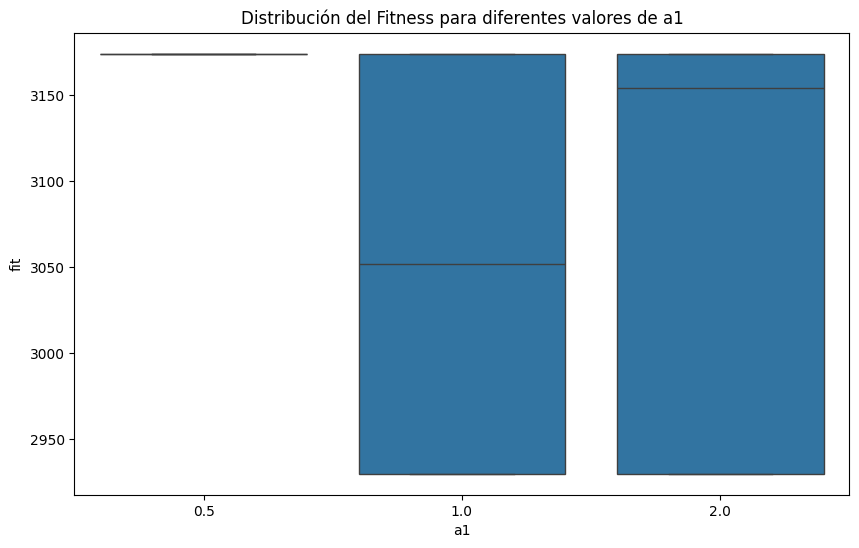